In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.models as models
import torchvision.transforms as T
import numpy as np
import h5py
import os
import sys
import datetime
import csv

import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import logging
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset

# For visualize input
from torch.utils.tensorboard import SummaryWriter
import io
import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from PIL import Image

class EEGDataset(Dataset):
    '''
    Custom Dataset object for PyTorch to load the dataset
    '''
    def __init__(self, x, y, train, val):
        super(EEGDataset).__init__()
        assert x.shape[0] == y.size
        self.x = x
        self.y = [y[i][0] for i in range(y.size)]
        self.train = train
        self.val = val

    def __getitem__(self,key):
        return (self.x[key], self.y[key])

    def __len__(self):
        return len(self.y)

class Logger():
    '''
    Object controlling how information will be logged
    A logger created globally will be used to log all information
    Create a Logger(mode='debug') to have everything print to the console
    '''
    def __init__(self, mode='log'):
        self.mode = mode
        
    def set_model_save_location(self, model_dir):
        self.model_dir = f"saved-model/{model_dir}"
        if not os.path.isdir(self.model_dir):
            os.mkdir(self.model_dir)
        
    def set_experiment(self, experiment_name):
        self.experiment_name = experiment_name
        log_format = '%(asctime)s %(message)s'
        logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                            format=log_format, datefmt='%m/%d %I:%M:%S %p')
        fh = logging.FileHandler(os.path.join('training-logs', f'log-{experiment_name}-{datetime.datetime.today()}.txt'))
        fh.setFormatter(logging.Formatter(log_format))
        logging.getLogger().addHandler(fh)
        self.writer = SummaryWriter(f"runs/{experiment_name}")
            
    def log(self, message=""):
        if self.mode == 'log':
            logging.info(message)
        elif self.mode == 'debug':
            print(message)

    def save_model(self, model, info):
        torch.save(model.state_dict(), f"{self.model_dir}/model-{logger.experiment_name}-{info}")
        
def load_data(path, role, winLength, numChan, srate, feature, one_channel=False, version=""):
    """
    Load dataset
    :param  
        path: Filepath to the dataset
        role: Role of the dataset. Can be "train", "val", or "test"
        winLength: Length of time window. Can be 2 or 15
        numChan: Number of channels. Can be 24 or 128
        srate: Sampling rate. Supporting 126Hz
        feature: Input feature. Can be "raw", "spectral", or "topo"
        one_channel: Whether input has 1 or 3 channel in depth dimension. Matters when load topo data as number of input channels 
                are different from original's
        version: Any additional information of the datafile. Will be appended to the file name at the end
    """
    transform = T.Compose([
        T.ToTensor()
    ])
    if version:
        f = h5py.File(path + f"child_mind_x_{role}_{winLength}s_{numChan}chan_{feature}_{version}.mat", 'r')
    else:
        f = h5py.File(path + f"child_mind_x_{role}_{winLength}s_{numChan}chan_{feature}.mat", 'r')
    x = f[f'X_{role}']
    if feature == 'raw':
        x = np.transpose(x,(0,2,1))
        x = np.reshape(x,(-1,numChan,winLength*srate))
    elif feature == 'topo':
        if one_channel:
            samples = []
            for i in range(x.shape[0]):
                image = x[i]
                b, g, r = image[0,:, :], image[1,:, :], image[2,:, :]
                concat = np.concatenate((b,g,r), axis=1)
                samples.append(concat)
            x = np.stack(samples)
            x = np.reshape(x,(-1,1,x.shape[1],x.shape[2]))
    
    if version:
        f = h5py.File(path + f"child_mind_yclass1_ages_{role}_{winLength}s_{numChan}chan_{feature}_{version}.mat", 'r')
    else:
        f = h5py.File(path + f"child_mind_yclass1_ages_{role}_{winLength}s_{numChan}chan_{feature}.mat", 'r')
    y = np.subtract(f[f'Y_cls_{role}'], 1)
   
    return x,y



def plot_to_image_tensor(figure):
    # Save the plot to a PNG in memory.
    figure.savefig('batch.png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    img = Image.open('batch.png')
    trans = transforms.ToPILImage()
    trans1 = transforms.ToTensor()
    image_tensor = trans1(img)
    return image_tensor

def plot_EEG(data, feature, numChan, one_channel=True):
    '''
    Plot EEG sample
    :param
        data: An EEGDataset object
        feature: String - 'raw' or 'topo'
        numChan: Int - number of EEG channels
        one_channel: Bool - Whether input has 1 or 3 channel in depth dimension. Matters when load topo data as number of input channels 
                are different from original's
    '''
    x_data = data[:][0]
    if feature == 'raw':        
        fig = plt.figure(figsize=(80, 80))
        outer = gridspec.GridSpec(8, 8)
        for i in range(64):
            inner = gridspec.GridSpecFromSubplotSpec(numChan, 1,
                            subplot_spec=outer[i])
#             npimg = img[i,:,:,:].numpy()
            npimg = x_data[i,:,:,:]
            npimg = np.reshape(npimg,(24,256))
            yax = None
            for j in range(24):
                ax = plt.Subplot(fig, inner[j])
                ax.plot(range(256),npimg[j,:],'k')
                ax.set_xticks([])
                ax.set_yticks([])
                fig.add_subplot(ax)

        return fig
    else:
        sample = 2
        if one_channel:
            image = np.reshape(x_data[sample], (x_data[sample].shape[1],x_data[sample].shape[2]))
            plt.imshow(image.astype('int32'))
        else:
            plt.imshow(np.transpose(x_data[sample].astype('int32'), (1, 2, 0)))
        plt.show()

In [2]:
# Load EEG data
path = './data/'
winLength = 2
numChan = 24
srate = 128
feature = 'raw'
one_channel = False

role = 'train'
train_data_x, train_data_labels = load_data(path, role, winLength, numChan, srate, feature, one_channel)
# print(f'X_train shape: {len(train_data)}, {train_data[0][0].shape}')
# print(f'Y_train shape: {len(train_data)}, {train_data[0][1].shape}')

role = 'val'
val_data_x, val_data_labels = load_data(path, role, winLength, numChan, srate, feature, one_channel)
# print(f'X_val shape: {len(val_data)}, {val_data[0][0].shape}')
# print(f'Y_val shape: {len(val_data)}, {val_data[0][1].shape}')
# EEGDataset(x, y, role=='train', role=='val')
# plot_EEG(train_data, feature, numChan, one_channel)

In [3]:
train_data_y = train_data_labels.copy()
train_data_y[np.logical_and(train_data_labels <= 2,train_data_labels >= 0)] = 0
train_data_y[train_data_labels > 2] = 1
val_data_y = val_data_labels.copy()
val_data_y[np.logical_and(val_data_labels <= 2,val_data_labels >= 0)] = 0
val_data_y[val_data_labels > 2] = 1

(array([43597.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 27784.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

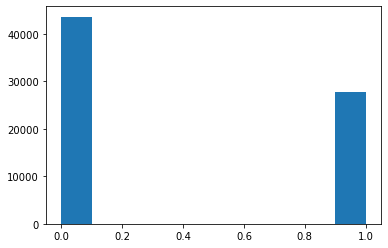

In [4]:
plt.hist(train_data_y)

In [5]:
43597/(43597+27784)

0.610764769336378

(array([24980.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 14888.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

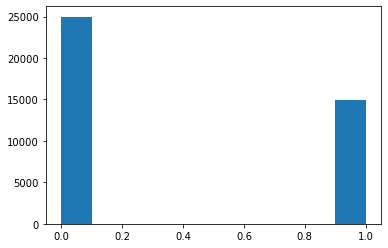

In [6]:
plt.hist(val_data_y)

In [7]:
24980/(24980+14888)

0.6265676733219625

In [8]:
train_data = EEGDataset(train_data_x, train_data_y, True, False)
val_data = EEGDataset(val_data_x, val_data_y, False, True)

In [9]:
# Initialize device information for PyTorch
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [10]:
def check_accuracy(loader, model):
    '''
    Check accuracy of the model 
    param:
        loader: An EEGDataset object
        model: A PyTorch Module to test
    '''
    if loader.dataset.train:
        logger.log('Checking accuracy on training set')
    elif loader.dataset.val:
        logger.log('Checking accuracy on validation set')
    else:
        logger.log('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    lossTotal = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            x=x.squeeze(1)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = F.cross_entropy(scores, y, weight=torch.tensor([class_0_weight,class_1_weight], dtype=dtype,device=device))
            lossTotal += loss.item()
#             print(f"label {y}, prediction {scores}")
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        lossTotal = lossTotal / len(loader)
        logger.log('Loss (%f)' % (loss))
        logger.log('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

        return acc,lossTotal

In [11]:
class_0_weight = 43597/(43597+27784)
class_1_weight = 1-class_0_weight
def train(model, loader_train, loader_val, optimizer, epochs=1):
    """
    Train a model using the PyTorch Module API.
    
    params:
        model: A PyTorch Module giving the model to train.
        loader_train: A PyTorch DataLoader object containing training data loaded in batch
        loader_val: A PyTorch DataLoader object containing validation data loaded in batch        
        optimizer: An Optimizer object we will use to train the model
        epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
#     mseLoss = nn.MSELoss()
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            x = x.squeeze(1)
#             y = y.to(device=device, dtype=dtype).unsqueeze(1)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
#             loss = mseLoss(scores, y)
            loss = F.cross_entropy(scores, y, weight=torch.tensor([class_0_weight,class_1_weight], dtype=dtype,device=device))
#             loss = F.binary_cross_entropy(torch.sigmoid(scores), y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                logger.log('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
        train_acc, train_loss = check_accuracy(loader_train, model)
        logger.writer.add_scalar("Loss/train", train_loss, e)
        logger.writer.add_scalar("Acc/train", train_acc, e)        
        val_acc, val_loss = check_accuracy(loader_val, model)
        logger.writer.add_scalar("Acc/val", val_acc, e)        
        logger.writer.add_scalar("Loss/val", val_loss, e)
        logger.log()
        
        # Save model every 20 epochs
        if e > 0 and e % 10 == 0:
            logger.save_model(model,f"epoch{e}")
        elif val_acc >= 0.7:
            logger.save_model(model,f"valacc{round(val_acc*100,2)}-epoch{e}")
    # save final model
    logger.save_model(model,f"epoch{e}")
    return model

In [12]:
def create_model():
    '''
    Create the CNN following configuration in https://arxiv.org/pdf/1611.08024.pdf
    '''
    model = nn.Sequential(
            nn.Conv1d(24,64,3),
            nn.ReLU(),
            nn.Conv1d(64,64,3),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(2, 2),
            nn.Flatten(),
            nn.Linear(8064,100),
            nn.ReLU(),
            nn.Linear(100,2)
        )
    return model


In [13]:
# Create and show model summary
model = create_model()
from pytorch_model_summary import summary
print(summary(model, torch.zeros((1, 24, 256)), show_input=False))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Conv1d-1        [1, 64, 254]           4,672           4,672
            ReLU-2        [1, 64, 254]               0               0
          Conv1d-3        [1, 64, 252]          12,352          12,352
            ReLU-4        [1, 64, 252]               0               0
         Dropout-5        [1, 64, 252]               0               0
       MaxPool1d-6        [1, 64, 126]               0               0
         Flatten-7           [1, 8064]               0               0
          Linear-8            [1, 100]         806,500         806,500
            ReLU-9            [1, 100]               0               0
         Linear-10              [1, 2]             202             202
Total params: 823,726
Trainable params: 823,726
Non-trainable params: 0
-----------------------------------------------------------------------


In [14]:
def test_model(model, test_data, subj_csv):
    '''
    Test model using two different metrics. First is per sample accuracy.
    Second is to use 40 samples per subject and perform voting:
        If mean prediction > 0.5, classify as female (1)
        Otherwise, classify as male (0)
    param:
        model: A trained PyTorch Module
        test_data: test dataset
        subj_csv: spreadsheet containing subject IDs for the test dataset
    '''
    # one-segment test
    logger.log('Testing model accuracy using 1-segment metric')
    loader_test = DataLoader(test_data, batch_size=70)
    per_sample_acc = check_accuracy(loader_test, model)

    # 40-segment test
    logger.log('Testing model accuracy using 40-segment per subject metric')
    with open(subj_csv, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        subjIDs = [row[0] for row in spamreader]
    unique_subjs,indices = np.unique(subjIDs,return_index=True)

    iterable_test_data = list(iter(DataLoader(test_data, batch_size=1)))
    num_correct = []
    for subj,idx in zip(unique_subjs,indices):
    #     print(f'Subj {subj} - gender {iterable_test_data[idx][1]}')
        data = iterable_test_data[idx:idx+40]
        #print(np.sum([y for _,y in data]))
        assert 40 == np.sum([y for _,y in data]) or 0 == np.sum([y for _,y in data])
        preds = []
        correct = 0
        with torch.no_grad():
            for x,y in data:
                x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
                correct = y
                scores = model(x)
                _, pred = scores.max(1)
                preds.append(pred)
        final_pred = (torch.mean(torch.FloatTensor(preds)) > 0.5).sum()
        num_correct.append((final_pred == correct).sum())
    #print(len(num_correct))
    acc = float(np.sum(num_correct)) / len(unique_subjs)
    logger.log('Got %d / %d correct (%.2f)' % (np.sum(num_correct), len(unique_subjs), 100 * acc))
    return per_sample_acc, acc

In [15]:
def run_experiment(seed, model_name, feature, loader_train, loader_val, num_epoch):
    '''
    Train a model for num_epoch given a random seed. 
    During training, logs and intemediary models will be saved in files accordingly to model_name
    param:
        seed: Int - Random seed number
        model_name: String - Name of the model to be saved. Used for logging
        feature: String - Whether 'raw' or 'topo'
        loader_train: DataLoader with training set
        loader_val: DataLoader with validation set
        num_epoch: Int - number of epoch to train the model
    '''
    model = create_model()
    logger.set_model_save_location(f'{model_name}-{feature}')
    experiment = f'{model_name}-{feature}-seed{seed}'
    logger.set_experiment(experiment)

    np.random.seed(seed)
    torch.manual_seed(seed)

    # toggle between learning rate and batch size values 

    optimizer = torch.optim.Adam(model.parameters())
    model = train(model, loader_train, loader_val, optimizer, epochs=num_epoch)
    
    return model

In [17]:
# train model multiple times, each with different random seed
logger = Logger() # initialize logger to be used throughout
experiment_name = 'original-ages-Conv1d-Adam'
batch_size = 256
loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(val_data, batch_size=batch_size)
for s in range(2, 10):
    model = run_experiment(s, experiment_name, 'raw',loader_train, loader_val,40)
# model = run_experiment(0, experiment_name, 'raw', loader_train, loader_val,70)

06/02 03:12:02 PM Epoch 0, Iteration 0, loss = 3.6760
06/02 03:12:04 PM Epoch 0, Iteration 100, loss = 0.6712
06/02 03:12:05 PM Epoch 0, Iteration 200, loss = 0.6404
06/02 03:12:05 PM Checking accuracy on training set
06/02 03:12:07 PM Loss (0.623404)
06/02 03:12:07 PM Got 43648 / 71381 correct (61.15)
06/02 03:12:07 PM Checking accuracy on validation set
06/02 03:12:07 PM Loss (0.511939)
06/02 03:12:07 PM Got 24985 / 39868 correct (62.67)
06/02 03:12:07 PM 
06/02 03:12:07 PM Epoch 1, Iteration 0, loss = 0.6282
06/02 03:12:08 PM Epoch 1, Iteration 100, loss = 0.5869
06/02 03:12:09 PM Epoch 1, Iteration 200, loss = 0.5723
06/02 03:12:10 PM Checking accuracy on training set
06/02 03:12:11 PM Loss (0.603270)
06/02 03:12:11 PM Got 43665 / 71381 correct (61.17)
06/02 03:12:11 PM Checking accuracy on validation set
06/02 03:12:12 PM Loss (0.331841)
06/02 03:12:12 PM Got 24985 / 39868 correct (62.67)
06/02 03:12:12 PM 
06/02 03:12:12 PM Epoch 2, Iteration 0, loss = 0.5861
06/02 03:12:13 PM Ep

06/02 03:13:28 PM Checking accuracy on validation set
06/02 03:13:29 PM Loss (0.230521)
06/02 03:13:29 PM Got 29199 / 39868 correct (73.24)
06/02 03:13:29 PM 
06/02 03:13:29 PM Epoch 18, Iteration 0, loss = 0.4470
06/02 03:13:30 PM Epoch 18, Iteration 100, loss = 0.4248
06/02 03:13:31 PM Epoch 18, Iteration 200, loss = 0.3990
06/02 03:13:31 PM Checking accuracy on training set
06/02 03:13:33 PM Loss (0.447157)
06/02 03:13:33 PM Got 55176 / 71381 correct (77.30)
06/02 03:13:33 PM Checking accuracy on validation set
06/02 03:13:33 PM Loss (0.205809)
06/02 03:13:33 PM Got 29198 / 39868 correct (73.24)
06/02 03:13:33 PM 
06/02 03:13:33 PM Epoch 19, Iteration 0, loss = 0.3963
06/02 03:13:34 PM Epoch 19, Iteration 100, loss = 0.4277
06/02 03:13:35 PM Epoch 19, Iteration 200, loss = 0.4089
06/02 03:13:36 PM Checking accuracy on training set
06/02 03:13:37 PM Loss (0.409553)
06/02 03:13:37 PM Got 54869 / 71381 correct (76.87)
06/02 03:13:37 PM Checking accuracy on validation set
06/02 03:13:38

06/02 03:14:52 PM Epoch 35, Iteration 200, loss = 0.4177
06/02 03:14:53 PM Checking accuracy on training set
06/02 03:14:54 PM Loss (0.443213)
06/02 03:14:54 PM Got 55505 / 71381 correct (77.76)
06/02 03:14:54 PM Checking accuracy on validation set
06/02 03:14:55 PM Loss (0.248284)
06/02 03:14:55 PM Got 29090 / 39868 correct (72.97)
06/02 03:14:55 PM 
06/02 03:14:55 PM Epoch 36, Iteration 0, loss = 0.5313
06/02 03:14:56 PM Epoch 36, Iteration 100, loss = 0.4572
06/02 03:14:57 PM Epoch 36, Iteration 200, loss = 0.4268
06/02 03:14:58 PM Checking accuracy on training set
06/02 03:14:59 PM Loss (0.412718)
06/02 03:14:59 PM Got 57414 / 71381 correct (80.43)
06/02 03:14:59 PM Checking accuracy on validation set
06/02 03:15:00 PM Loss (0.203428)
06/02 03:15:00 PM Got 29197 / 39868 correct (73.23)
06/02 03:15:00 PM 
06/02 03:15:00 PM Epoch 37, Iteration 0, loss = 0.3778
06/02 03:15:01 PM Epoch 37, Iteration 100, loss = 0.3529
06/02 03:15:02 PM Epoch 37, Iteration 200, loss = 0.4029
06/02 03:15

06/02 03:16:16 PM 
06/02 03:16:16 PM Epoch 13, Iteration 0, loss = 0.4259
06/02 03:16:17 PM Epoch 13, Iteration 100, loss = 0.5868
06/02 03:16:18 PM Epoch 13, Iteration 200, loss = 0.5732
06/02 03:16:19 PM Checking accuracy on training set
06/02 03:16:20 PM Loss (0.545378)
06/02 03:16:20 PM Got 46064 / 71381 correct (64.53)
06/02 03:16:20 PM Checking accuracy on validation set
06/02 03:16:21 PM Loss (0.309859)
06/02 03:16:21 PM Got 26118 / 39868 correct (65.51)
06/02 03:16:21 PM 
06/02 03:16:21 PM Epoch 14, Iteration 0, loss = 0.5862
06/02 03:16:22 PM Epoch 14, Iteration 100, loss = 0.5047
06/02 03:16:23 PM Epoch 14, Iteration 200, loss = 0.5243
06/02 03:16:24 PM Checking accuracy on training set
06/02 03:16:25 PM Loss (0.477283)
06/02 03:16:25 PM Got 49927 / 71381 correct (69.94)
06/02 03:16:25 PM Checking accuracy on validation set
06/02 03:16:25 PM Loss (0.232216)
06/02 03:16:25 PM Got 27488 / 39868 correct (68.95)
06/02 03:16:25 PM 
06/02 03:16:25 PM Epoch 15, Iteration 0, loss = 0

06/02 03:17:41 PM Got 53830 / 71381 correct (75.41)
06/02 03:17:41 PM Checking accuracy on validation set
06/02 03:17:42 PM Loss (0.197573)
06/02 03:17:42 PM Got 29003 / 39868 correct (72.75)
06/02 03:17:42 PM 
06/02 03:17:42 PM Epoch 31, Iteration 0, loss = 0.4164
06/02 03:17:43 PM Epoch 31, Iteration 100, loss = 0.4249
06/02 03:17:44 PM Epoch 31, Iteration 200, loss = 0.4795
06/02 03:17:45 PM Checking accuracy on training set
06/02 03:17:46 PM Loss (0.480147)
06/02 03:17:46 PM Got 53162 / 71381 correct (74.48)
06/02 03:17:46 PM Checking accuracy on validation set
06/02 03:17:47 PM Loss (0.185794)
06/02 03:17:47 PM Got 28790 / 39868 correct (72.21)
06/02 03:17:47 PM 
06/02 03:17:47 PM Epoch 32, Iteration 0, loss = 0.4844
06/02 03:17:48 PM Epoch 32, Iteration 100, loss = 0.4103
06/02 03:17:49 PM Epoch 32, Iteration 200, loss = 0.4600
06/02 03:17:50 PM Checking accuracy on training set
06/02 03:17:51 PM Loss (0.425331)
06/02 03:17:51 PM Got 55707 / 71381 correct (78.04)
06/02 03:17:51 P

06/02 03:19:05 PM Epoch 8, Iteration 200, loss = 0.5626
06/02 03:19:06 PM Checking accuracy on training set
06/02 03:19:07 PM Loss (0.508390)
06/02 03:19:07 PM Got 43597 / 71381 correct (61.08)
06/02 03:19:07 PM Checking accuracy on validation set
06/02 03:19:08 PM Loss (0.255425)
06/02 03:19:08 PM Got 24980 / 39868 correct (62.66)
06/02 03:19:08 PM 
06/02 03:19:08 PM Epoch 9, Iteration 0, loss = 0.5505
06/02 03:19:09 PM Epoch 9, Iteration 100, loss = 0.5386
06/02 03:19:10 PM Epoch 9, Iteration 200, loss = 0.5353
06/02 03:19:10 PM Checking accuracy on training set
06/02 03:19:12 PM Loss (0.557053)
06/02 03:19:12 PM Got 43594 / 71381 correct (61.07)
06/02 03:19:12 PM Checking accuracy on validation set
06/02 03:19:12 PM Loss (0.331671)
06/02 03:19:12 PM Got 24979 / 39868 correct (62.65)
06/02 03:19:12 PM 
06/02 03:19:12 PM Epoch 10, Iteration 0, loss = 0.5250
06/02 03:19:13 PM Epoch 10, Iteration 100, loss = 0.5686
06/02 03:19:14 PM Epoch 10, Iteration 200, loss = 0.5192
06/02 03:19:15 

06/02 03:20:29 PM Got 28142 / 39868 correct (70.59)
06/02 03:20:29 PM 
06/02 03:20:29 PM Epoch 26, Iteration 0, loss = 0.3876
06/02 03:20:30 PM Epoch 26, Iteration 100, loss = 0.4335
06/02 03:20:31 PM Epoch 26, Iteration 200, loss = 0.3488
06/02 03:20:32 PM Checking accuracy on training set
06/02 03:20:33 PM Loss (0.412034)
06/02 03:20:33 PM Got 57372 / 71381 correct (80.37)
06/02 03:20:33 PM Checking accuracy on validation set
06/02 03:20:34 PM Loss (0.183632)
06/02 03:20:34 PM Got 28707 / 39868 correct (72.01)
06/02 03:20:34 PM 
06/02 03:20:34 PM Epoch 27, Iteration 0, loss = 0.3998
06/02 03:20:35 PM Epoch 27, Iteration 100, loss = 0.4109
06/02 03:20:36 PM Epoch 27, Iteration 200, loss = 0.4117
06/02 03:20:36 PM Checking accuracy on training set
06/02 03:20:38 PM Loss (0.419421)
06/02 03:20:38 PM Got 57167 / 71381 correct (80.09)
06/02 03:20:38 PM Checking accuracy on validation set
06/02 03:20:38 PM Loss (0.251698)
06/02 03:20:38 PM Got 28548 / 39868 correct (71.61)
06/02 03:20:38 P

06/02 03:21:54 PM Loss (0.564779)
06/02 03:21:54 PM Got 49244 / 71381 correct (68.99)
06/02 03:21:54 PM Checking accuracy on validation set
06/02 03:21:55 PM Loss (0.220964)
06/02 03:21:55 PM Got 27305 / 39868 correct (68.49)
06/02 03:21:55 PM 
06/02 03:21:55 PM Epoch 4, Iteration 0, loss = 0.5416
06/02 03:21:56 PM Epoch 4, Iteration 100, loss = 0.5403
06/02 03:21:57 PM Epoch 4, Iteration 200, loss = 0.4999
06/02 03:21:57 PM Checking accuracy on training set
06/02 03:21:59 PM Loss (0.502333)
06/02 03:21:59 PM Got 51679 / 71381 correct (72.40)
06/02 03:21:59 PM Checking accuracy on validation set
06/02 03:21:59 PM Loss (0.228522)
06/02 03:21:59 PM Got 28278 / 39868 correct (70.93)
06/02 03:21:59 PM 
06/02 03:21:59 PM Epoch 5, Iteration 0, loss = 0.5109
06/02 03:22:00 PM Epoch 5, Iteration 100, loss = 0.4593
06/02 03:22:01 PM Epoch 5, Iteration 200, loss = 0.5449
06/02 03:22:02 PM Checking accuracy on training set
06/02 03:22:03 PM Loss (0.496548)
06/02 03:22:03 PM Got 50061 / 71381 corr

06/02 03:23:16 PM Epoch 21, Iteration 100, loss = 0.6304
06/02 03:23:17 PM Epoch 21, Iteration 200, loss = 0.6327
06/02 03:23:18 PM Checking accuracy on training set
06/02 03:23:19 PM Loss (0.625260)
06/02 03:23:19 PM Got 43597 / 71381 correct (61.08)
06/02 03:23:19 PM Checking accuracy on validation set
06/02 03:23:20 PM Loss (0.343380)
06/02 03:23:20 PM Got 24980 / 39868 correct (62.66)
06/02 03:23:20 PM 
06/02 03:23:20 PM Epoch 22, Iteration 0, loss = 0.6123
06/02 03:23:21 PM Epoch 22, Iteration 100, loss = 0.5725
06/02 03:23:22 PM Epoch 22, Iteration 200, loss = 0.5874
06/02 03:23:23 PM Checking accuracy on training set
06/02 03:23:24 PM Loss (0.616428)
06/02 03:23:24 PM Got 43597 / 71381 correct (61.08)
06/02 03:23:24 PM Checking accuracy on validation set
06/02 03:23:25 PM Loss (0.338146)
06/02 03:23:25 PM Got 24980 / 39868 correct (62.66)
06/02 03:23:25 PM 
06/02 03:23:25 PM Epoch 23, Iteration 0, loss = 0.5969
06/02 03:23:26 PM Epoch 23, Iteration 100, loss = 0.6308
06/02 03:23

06/02 03:24:41 PM Loss (0.342820)
06/02 03:24:41 PM Got 24924 / 39868 correct (62.52)
06/02 03:24:41 PM 
06/02 03:24:41 PM Epoch 39, Iteration 0, loss = 0.5885
06/02 03:24:42 PM Epoch 39, Iteration 100, loss = 0.5676
06/02 03:24:43 PM Epoch 39, Iteration 200, loss = 0.6057
06/02 03:24:44 PM Checking accuracy on training set
06/02 03:24:45 PM Loss (0.576039)
06/02 03:24:45 PM Got 43616 / 71381 correct (61.10)
06/02 03:24:45 PM Checking accuracy on validation set
06/02 03:24:45 PM Loss (0.339843)
06/02 03:24:45 PM Got 24973 / 39868 correct (62.64)
06/02 03:24:45 PM 
06/02 03:24:46 PM Epoch 0, Iteration 0, loss = 5.5805
06/02 03:24:47 PM Epoch 0, Iteration 100, loss = 0.6762
06/02 03:24:48 PM Epoch 0, Iteration 200, loss = 0.6473
06/02 03:24:48 PM Checking accuracy on training set
06/02 03:24:50 PM Loss (0.641453)
06/02 03:24:50 PM Got 43597 / 71381 correct (61.08)
06/02 03:24:50 PM Checking accuracy on validation set
06/02 03:24:50 PM Loss (0.525871)
06/02 03:24:50 PM Got 24980 / 39868 c

06/02 03:26:06 PM Loss (0.575965)
06/02 03:26:06 PM Got 43597 / 71381 correct (61.08)
06/02 03:26:06 PM Checking accuracy on validation set
06/02 03:26:06 PM Loss (0.338332)
06/02 03:26:06 PM Got 24980 / 39868 correct (62.66)
06/02 03:26:06 PM 
06/02 03:26:06 PM Epoch 17, Iteration 0, loss = 0.6053
06/02 03:26:07 PM Epoch 17, Iteration 100, loss = 0.6176
06/02 03:26:08 PM Epoch 17, Iteration 200, loss = 0.6393
06/02 03:26:09 PM Checking accuracy on training set
06/02 03:26:10 PM Loss (0.623606)
06/02 03:26:10 PM Got 43597 / 71381 correct (61.08)
06/02 03:26:10 PM Checking accuracy on validation set
06/02 03:26:11 PM Loss (0.341320)
06/02 03:26:11 PM Got 24980 / 39868 correct (62.66)
06/02 03:26:11 PM 
06/02 03:26:11 PM Epoch 18, Iteration 0, loss = 0.5723
06/02 03:26:12 PM Epoch 18, Iteration 100, loss = 0.6022
06/02 03:26:13 PM Epoch 18, Iteration 200, loss = 0.5900
06/02 03:26:14 PM Checking accuracy on training set
06/02 03:26:15 PM Loss (0.573038)
06/02 03:26:15 PM Got 43597 / 7138

06/02 03:27:28 PM Epoch 34, Iteration 100, loss = 0.6022
06/02 03:27:29 PM Epoch 34, Iteration 200, loss = 0.6206
06/02 03:27:30 PM Checking accuracy on training set
06/02 03:27:31 PM Loss (0.590405)
06/02 03:27:31 PM Got 43597 / 71381 correct (61.08)
06/02 03:27:31 PM Checking accuracy on validation set
06/02 03:27:32 PM Loss (0.337135)
06/02 03:27:32 PM Got 24980 / 39868 correct (62.66)
06/02 03:27:32 PM 
06/02 03:27:32 PM Epoch 35, Iteration 0, loss = 0.5899
06/02 03:27:33 PM Epoch 35, Iteration 100, loss = 0.5870
06/02 03:27:34 PM Epoch 35, Iteration 200, loss = 0.5754
06/02 03:27:35 PM Checking accuracy on training set
06/02 03:27:36 PM Loss (0.627377)
06/02 03:27:36 PM Got 43597 / 71381 correct (61.08)
06/02 03:27:36 PM Checking accuracy on validation set
06/02 03:27:37 PM Loss (0.341073)
06/02 03:27:37 PM Got 24980 / 39868 correct (62.66)
06/02 03:27:37 PM 
06/02 03:27:37 PM Epoch 36, Iteration 0, loss = 0.5841
06/02 03:27:38 PM Epoch 36, Iteration 100, loss = 0.6391
06/02 03:27

06/02 03:28:53 PM Loss (0.176664)
06/02 03:28:53 PM Got 29209 / 39868 correct (73.26)
06/02 03:28:53 PM 
06/02 03:28:53 PM Epoch 12, Iteration 0, loss = 0.3976
06/02 03:28:54 PM Epoch 12, Iteration 100, loss = 0.4795
06/02 03:28:55 PM Epoch 12, Iteration 200, loss = 0.6071
06/02 03:28:56 PM Checking accuracy on training set
06/02 03:28:57 PM Loss (0.512306)
06/02 03:28:57 PM Got 48061 / 71381 correct (67.33)
06/02 03:28:57 PM Checking accuracy on validation set
06/02 03:28:58 PM Loss (0.264283)
06/02 03:28:58 PM Got 26856 / 39868 correct (67.36)
06/02 03:28:58 PM 
06/02 03:28:58 PM Epoch 13, Iteration 0, loss = 0.5049
06/02 03:28:59 PM Epoch 13, Iteration 100, loss = 0.4617
06/02 03:29:00 PM Epoch 13, Iteration 200, loss = 0.4167
06/02 03:29:01 PM Checking accuracy on training set
06/02 03:29:02 PM Loss (0.484392)
06/02 03:29:02 PM Got 53623 / 71381 correct (75.12)
06/02 03:29:02 PM Checking accuracy on validation set
06/02 03:29:02 PM Loss (0.192318)
06/02 03:29:02 PM Got 29074 / 3986

06/02 03:30:18 PM Checking accuracy on training set
06/02 03:30:19 PM Loss (0.369390)
06/02 03:30:19 PM Got 56788 / 71381 correct (79.56)
06/02 03:30:19 PM Checking accuracy on validation set
06/02 03:30:20 PM Loss (0.177877)
06/02 03:30:20 PM Got 29511 / 39868 correct (74.02)
06/02 03:30:20 PM 
06/02 03:30:20 PM Epoch 30, Iteration 0, loss = 0.3585
06/02 03:30:21 PM Epoch 30, Iteration 100, loss = 0.3537
06/02 03:30:22 PM Epoch 30, Iteration 200, loss = 0.3897
06/02 03:30:23 PM Checking accuracy on training set
06/02 03:30:24 PM Loss (0.380613)
06/02 03:30:24 PM Got 56781 / 71381 correct (79.55)
06/02 03:30:24 PM Checking accuracy on validation set
06/02 03:30:24 PM Loss (0.221987)
06/02 03:30:24 PM Got 29467 / 39868 correct (73.91)
06/02 03:30:24 PM 
06/02 03:30:25 PM Epoch 31, Iteration 0, loss = 0.3774
06/02 03:30:26 PM Epoch 31, Iteration 100, loss = 0.4476
06/02 03:30:27 PM Epoch 31, Iteration 200, loss = 0.3973
06/02 03:30:27 PM Checking accuracy on training set
06/02 03:30:29 P

06/02 03:31:41 PM Epoch 7, Iteration 0, loss = 0.4556
06/02 03:31:42 PM Epoch 7, Iteration 100, loss = 0.4615
06/02 03:31:43 PM Epoch 7, Iteration 200, loss = 0.5288
06/02 03:31:44 PM Checking accuracy on training set
06/02 03:31:46 PM Loss (0.500590)
06/02 03:31:46 PM Got 50816 / 71381 correct (71.19)
06/02 03:31:46 PM Checking accuracy on validation set
06/02 03:31:46 PM Loss (0.219642)
06/02 03:31:46 PM Got 27730 / 39868 correct (69.55)
06/02 03:31:46 PM 
06/02 03:31:46 PM Epoch 8, Iteration 0, loss = 0.4546
06/02 03:31:47 PM Epoch 8, Iteration 100, loss = 0.5182
06/02 03:31:48 PM Epoch 8, Iteration 200, loss = 0.5019
06/02 03:31:49 PM Checking accuracy on training set
06/02 03:31:50 PM Loss (0.465254)
06/02 03:31:50 PM Got 51511 / 71381 correct (72.16)
06/02 03:31:50 PM Checking accuracy on validation set
06/02 03:31:51 PM Loss (0.159883)
06/02 03:31:51 PM Got 27988 / 39868 correct (70.20)
06/02 03:31:51 PM 
06/02 03:31:51 PM Epoch 9, Iteration 0, loss = 0.4862
06/02 03:31:52 PM Ep

06/02 03:33:07 PM Checking accuracy on validation set
06/02 03:33:08 PM Loss (0.194527)
06/02 03:33:08 PM Got 29474 / 39868 correct (73.93)
06/02 03:33:08 PM 
06/02 03:33:08 PM Epoch 25, Iteration 0, loss = 0.3649
06/02 03:33:09 PM Epoch 25, Iteration 100, loss = 0.4008
06/02 03:33:10 PM Epoch 25, Iteration 200, loss = 0.3819
06/02 03:33:11 PM Checking accuracy on training set
06/02 03:33:12 PM Loss (0.377903)
06/02 03:33:12 PM Got 58107 / 71381 correct (81.40)
06/02 03:33:12 PM Checking accuracy on validation set
06/02 03:33:13 PM Loss (0.178939)
06/02 03:33:13 PM Got 29268 / 39868 correct (73.41)
06/02 03:33:13 PM 
06/02 03:33:13 PM Epoch 26, Iteration 0, loss = 0.3731
06/02 03:33:14 PM Epoch 26, Iteration 100, loss = 0.3853
06/02 03:33:15 PM Epoch 26, Iteration 200, loss = 0.3855
06/02 03:33:16 PM Checking accuracy on training set
06/02 03:33:17 PM Loss (0.379135)
06/02 03:33:17 PM Got 57298 / 71381 correct (80.27)
06/02 03:33:17 PM Checking accuracy on validation set
06/02 03:33:17

06/02 03:34:32 PM Checking accuracy on training set
06/02 03:34:33 PM Loss (0.536591)
06/02 03:34:33 PM Got 44199 / 71381 correct (61.92)
06/02 03:34:33 PM Checking accuracy on validation set
06/02 03:34:34 PM Loss (0.246492)
06/02 03:34:34 PM Got 25279 / 39868 correct (63.41)
06/02 03:34:34 PM 
06/02 03:34:34 PM Epoch 3, Iteration 0, loss = 0.5015
06/02 03:34:35 PM Epoch 3, Iteration 100, loss = 0.5709
06/02 03:34:36 PM Epoch 3, Iteration 200, loss = 0.5749
06/02 03:34:37 PM Checking accuracy on training set
06/02 03:34:38 PM Loss (0.558653)
06/02 03:34:38 PM Got 45820 / 71381 correct (64.19)
06/02 03:34:38 PM Checking accuracy on validation set
06/02 03:34:39 PM Loss (0.211629)
06/02 03:34:39 PM Got 26200 / 39868 correct (65.72)
06/02 03:34:39 PM 
06/02 03:34:39 PM Epoch 4, Iteration 0, loss = 0.5712
06/02 03:34:40 PM Epoch 4, Iteration 100, loss = 0.5126
06/02 03:34:41 PM Epoch 4, Iteration 200, loss = 0.5277
06/02 03:34:41 PM Checking accuracy on training set
06/02 03:34:43 PM Loss

06/02 03:35:55 PM Epoch 20, Iteration 0, loss = 0.6118
06/02 03:35:56 PM Epoch 20, Iteration 100, loss = 0.5568
06/02 03:35:57 PM Epoch 20, Iteration 200, loss = 0.5272
06/02 03:35:58 PM Checking accuracy on training set
06/02 03:35:59 PM Loss (0.571461)
06/02 03:35:59 PM Got 43602 / 71381 correct (61.08)
06/02 03:35:59 PM Checking accuracy on validation set
06/02 03:36:00 PM Loss (0.242713)
06/02 03:36:00 PM Got 24965 / 39868 correct (62.62)
06/02 03:36:00 PM 
06/02 03:36:00 PM Epoch 21, Iteration 0, loss = 0.5368
06/02 03:36:01 PM Epoch 21, Iteration 100, loss = 0.6344
06/02 03:36:02 PM Epoch 21, Iteration 200, loss = 0.5147
06/02 03:36:02 PM Checking accuracy on training set
06/02 03:36:04 PM Loss (0.580060)
06/02 03:36:04 PM Got 43598 / 71381 correct (61.08)
06/02 03:36:04 PM Checking accuracy on validation set
06/02 03:36:04 PM Loss (0.345859)
06/02 03:36:04 PM Got 24977 / 39868 correct (62.65)
06/02 03:36:04 PM 
06/02 03:36:04 PM Epoch 22, Iteration 0, loss = 0.5807
06/02 03:36:0

06/02 03:37:20 PM Checking accuracy on validation set
06/02 03:37:21 PM Loss (0.149817)
06/02 03:37:21 PM Got 29287 / 39868 correct (73.46)
06/02 03:37:21 PM 
06/02 03:37:21 PM Epoch 38, Iteration 0, loss = 0.4050
06/02 03:37:22 PM Epoch 38, Iteration 100, loss = 0.4064
06/02 03:37:23 PM Epoch 38, Iteration 200, loss = 0.3759
06/02 03:37:24 PM Checking accuracy on training set
06/02 03:37:25 PM Loss (0.423505)
06/02 03:37:25 PM Got 56129 / 71381 correct (78.63)
06/02 03:37:25 PM Checking accuracy on validation set
06/02 03:37:26 PM Loss (0.156915)
06/02 03:37:26 PM Got 29614 / 39868 correct (74.28)
06/02 03:37:26 PM 
06/02 03:37:26 PM Epoch 39, Iteration 0, loss = 0.4435
06/02 03:37:27 PM Epoch 39, Iteration 100, loss = 0.3391
06/02 03:37:28 PM Epoch 39, Iteration 200, loss = 0.4223
06/02 03:37:29 PM Checking accuracy on training set
06/02 03:37:30 PM Loss (0.522937)
06/02 03:37:30 PM Got 52023 / 71381 correct (72.88)
06/02 03:37:30 PM Checking accuracy on validation set
06/02 03:37:31

In [15]:
test_data_x, test_data_labels = load_data(path, 'test', winLength, numChan, srate, feature, one_channel)
test_data_y = test_data_labels.copy()
test_data_y[np.logical_and(test_data_labels <= 2,test_data_labels >= 0)] = 0
test_data_y[test_data_labels > 2] = 1
test_data = EEGDataset(test_data_x, test_data_y, False, False)

(array([8797.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        7128.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

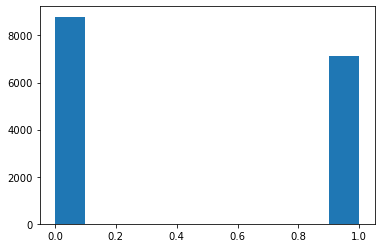

In [16]:
plt.hist(test_data_y)

In [17]:
8797/(8797+7128)

0.5524018838304553

In [24]:
def confusion_matrix(loader, model):
    '''
    Check accuracy and get confusion matrix of the model 
    param:
        loader: An EEGDataset object
        model: A PyTorch Module to test
    '''
    if loader.dataset.train:
        logger.log('Checking accuracy on training set')
    elif loader.dataset.val:
        logger.log('Checking accuracy on validation set')
    else:
        logger.log('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    model.eval()  # set model to evaluation mode
    lossTotal = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            x = x.squeeze(1)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = F.cross_entropy(scores, y, weight=torch.tensor([class_0_weight,class_1_weight], dtype=dtype,device=device))
            lossTotal += loss.item()
#             print(f"label {y}, prediction {scores}")
            _, preds = scores.max(1)
            class_0 = y==0
            class_1 = y==1
            tp += (preds[class_1] == y[class_1]).sum()
            tn += (preds[class_0] == y[class_0]).sum()
            fp += (y[class_0] != preds[class_0]).sum()
            fn += (y[class_1] != preds[class_1]).sum()
            num_correct += (preds == y).sum()
            assert num_correct == (tp+tn)
            num_samples += preds.size(0)
    precision = tp/(tp+fp)
    acc = float(num_correct) / num_samples
    lossTotal = lossTotal / len(loader)
    logger.log('Loss (%f)' % (loss))
    logger.log('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    logger.log('Precision: (%.2f)' % (precision))
    
    return acc,lossTotal,tp,tn,fp,fn

In [32]:
model.load_state_dict(torch.load('./saved-model/original-ages-Conv1d-Adam-raw/model-original-ages-Conv1d-Adam-raw-seed9-valacc74.09-epoch35'))

<All keys matched successfully>

In [33]:
logger = Logger(mode='debug')
loader_test = DataLoader(test_data, batch_size=1)
model.to(device=device)
acc,lossTotal,tp,tn,fp,fn = confusion_matrix(loader_test, model)

Checking accuracy on test set
Loss (0.327033)
Got 11359 / 15925 correct (71.33)
Precision: (0.83)


In [31]:
print(f'tp: {tp}')
print(f'tn: {tn}')
print(f'fp: {fp}')
print(f'fn: {fn}')
print(f'precision: {tp/(tp+fp)}')
print(f'recall: {tp/(tp+fn)}')

tp: 3600
tn: 7799
fp: 998
fn: 3528
precision: 0.7829490900039673
recall: 0.5050504803657532


In [ ]:
def test_all_seeds(partial_model_path, epoch, num_seed, isBalanced=True):
    '''
    Given name of saved model and epoch, check test accuracy for all random seeds in range(num_seed)
    
    '''
    if isBalanced:
        logger.log('Testing on balanced test set')
        test_data = load_data(path, 'test', winLength, numChan, srate, feature,'v2')
        subjIDs_file = 'data/test_subjIDs_fewer_subjects.csv'
    else:
        logger.log('Testing on all male test set')
        test_data = load_data(path, 'test', winLength, numChan, srate, feature,'v3')
        subjIDs_file = 'data/test_subjIDs_more_test.csv'

    sample_acc = []
    subject_acc = []
    for s in range(num_seed):
        model = create_model()
        model.load_state_dict(torch.load(f'{partial_model_path}-seed{s}-epoch{epoch}'))
        model.to(device=device)
        sam_acc, sub_acc = test_model(model, test_data,subjIDs_file)
        sample_acc.append(sam_acc)
        subject_acc.append(sub_acc)
        
    sample_acc = np.multiply(sample_acc,100)
    subject_acc = np.multiply(subject_acc,100)
    return sample_acc, subject_acc

In [12]:
logger = Logger(mode='debug')
# Compute test performance statistics for all intermidiary saved-models at each specified epochs
# and save result to a csv file
epochs = [40, 50, 60, 69]

with open("original-relu-raw-test-results-balanced.csv", 'w') as out:
    out.write('epoch,min_sam,max_sam,mean_sam,std_sam,min_subj,max_subj,mean_subj,std_subj\n')
    for epoch in epochs:
        sample_acc, subject_acc = test_all_seeds(partial_model_path="saved-model/original-relu-raw/model-original-relu-raw", epoch=epoch, num_seed=10, isBalanced=True)

        min_sample = np.min(sample_acc)
        max_sample = np.max(sample_acc)
        mean_sample = np.mean(sample_acc)
        std_sample = np.std(sample_acc)

        min_subj = np.min(subject_acc)
        max_subj = np.max(subject_acc)
        mean_subj = np.mean(subject_acc)
        std_subj = np.std(subject_acc)

        logger.log("Per sample")
        logger.log(f"Min: {min_sample}, Max: {max_sample}, Mean: {mean_sample}, STDEV: {std_sample}")

        logger.log("Per subject")
        logger.log(f"Min: {min_subj}, Max: {max_subj}, Mean: {mean_subj}, STDEV: {std_subj}")
        out.write(f"{epoch},{min_sample},{max_sample},{mean_sample},{std_sample},{min_subj},{max_subj},{mean_subj},{std_subj}\n")
        

Testing on balanced test set
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 13172 / 15925 correct (82.71)
Testing model accuracy using 40-segment per subject metric
Got 170 / 197 correct (86.29)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 13102 / 15925 correct (82.27)
Testing model accuracy using 40-segment per subject metric
Got 169 / 197 correct (85.79)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12874 / 15925 correct (80.84)
Testing model accuracy using 40-segment per subject metric
Got 168 / 197 correct (85.28)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12761 / 15925 correct (80.13)
Testing model accuracy using 40-segment per subject metric
Got 165 / 197 correct (83.76)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12477 / 15925 correct (78.35)
Testing model accuracy using 40-segment per subject metric
Got 16

Got 12758 / 15925 correct (80.11)
Testing model accuracy using 40-segment per subject metric
Got 165 / 197 correct (83.76)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 13029 / 15925 correct (81.81)
Testing model accuracy using 40-segment per subject metric
Got 166 / 197 correct (84.26)
Testing model accuracy using 1-segment metric
Checking accuracy on test set
Got 12702 / 15925 correct (79.76)
Testing model accuracy using 40-segment per subject metric
Got 166 / 197 correct (84.26)
Per sample
Min: 79.76138147566719, Max: 82.49921507064364, Mean: 81.3839874411303, STDEV: 0.9317428732667018
Per subject
Min: 83.75634517766497, Max: 88.83248730964468, Mean: 86.09137055837564, STDEV: 1.686624134602657
